# Exploration

In [1]:
from array import array
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
import numpy as np

def lookup(s,f):
    """
    Function used to parse the date 
    """
    dates = {date:pd.to_datetime(date,format=f) for date in s.unique()}
    return s.map(dates)

fdt_columns = ['Lcd1','Road_LCD', 'Road_name','Offset', 'Direction', 'Latitude', 'Longitude', 'Accuracy', 'Period', 'Date', 'Flow', 'Speed'];
fdt_df = pd.read_csv('fdt.csv', names=fdt_columns, header=0, sep=";");
fdt_df['Date'] = lookup(fdt_df['Date'],'%d-%b-%H:%M:%S-%Z-%Y')

In [2]:
fdt_df.head()

,Lcd1,Road_LCD,Road_name,Offset,Direction,Latitude,Longitude,Accuracy,Period,Date,Flow,Speed
0,39987,39985,Corso Belgio(TO),1396,negative,45.07479,7.72452,100,5,2016-12-08 18:10:01,420.0,17.92
1,40040,40039,Corso Giulio Cesare(TO),414,positive,45.11606,7.70910,100,5,2016-12-08 18:10:01,936.0,50.20
2,40174,40172,Corso Trieste(TO),704,positive,45.01515,7.66891,100,5,2016-12-08 18:10:01,2580.0,44.31
3,40183,40180,Corso Unione Sovietica(TO),988,negative,45.01608,7.62745,100,5,2016-12-08 18:10:01,1008.0,40.09
4,40021,40017,Corso Francia(TO),549,positive,45.07420,7.61264,100,5,2016-12-08 18:10:01,852.0,46.51


### Accuracy inspection

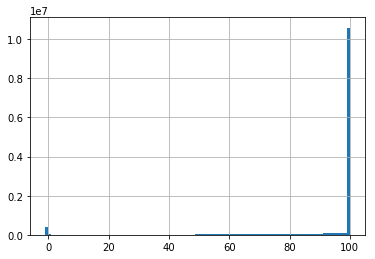

In [99]:
# Accuracy distribution
fdt_df['Accuracy'].hist(bins=102)
plt.show()

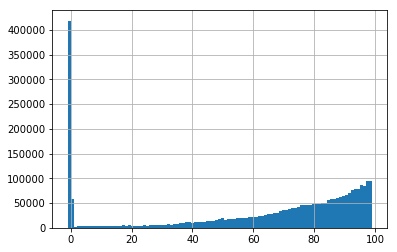

In [100]:
# Accuracy (<100%) distribution
fdt_df[ fdt_df['Accuracy']<100 ]['Accuracy'].hist(bins=101)
plt.show()

In [101]:
damaged = fdt_df[fdt_df['Accuracy']==-1]['Lcd1'].unique();
a_count = fdt_df[fdt_df['Lcd1'].isin(damaged)].groupby(['Lcd1','Road_name'])['Lcd1'].count()
d_count = fdt_df[fdt_df['Accuracy']==-1 ].groupby(['Lcd1','Road_name'])['Lcd1'].count();
perc = d_count/a_count*100
perc.sort_values(ascending=False)


Lcd1   Road_name                  
40266  Via Cernaia(TO)                100.000000
40092  Corso Novara(TO)               100.000000
39977  Corso Agnelli(TO)               88.828606
40298  Via S. Maria Mazzarello(TO)     80.281690
39986  Corso Belgio(TO)                70.081899
40262  Via Botticelli(TO)              57.898078
40064  Corso Maroncelli(TO)            55.662838
4856   SS23 Del Colle Di Sestriere     19.320465
40090  Corso Novara(TO)                13.486906
40044  Corso Giulio Cesare(TO)          8.463146
40291  Via Pietro Micca(TO)             4.901155
40041  Corso Giulio Cesare(TO)          4.673838
40123  Corso Regina Margherita(TO)      2.920292
40040  Corso Giulio Cesare(TO)          2.196050
40078  Corso Monte Cucco(TO)            1.384627
40097  Corso Orbassano(TO)              0.034015
Name: Lcd1, dtype: float64

In [102]:
# Remove measurements with accuracy < 80%
fdt_df = fdt_df[fdt_df['Accuracy']>80];

### Avg speed per (Lcd1, Road_name)

In [103]:
speed_avg = fdt_df.groupby(['Road_name', 'Lcd1'])['Speed'].mean().to_frame().reset_index()
speed_avg.columns=['Road_name', 'Lcd1','Avg_speed']
speed_avg.head()

,Road_name,Lcd1,Avg_speed
0,Corso Agnelli(TO),39976,40.785637
1,Corso Agnelli(TO),39977,39.834844
2,Corso Agnelli(TO),39978,32.053441
3,Corso Agnelli(TO),39979,28.515671
4,Corso Belgio(TO),39986,19.250835


### Best and worst hour slot per (Lcd1, Road_name)

In [104]:
fdt_df = fdt_df.assign(Hour_of_day=pd.DatetimeIndex(fdt_df['Date']).hour)
avg_speed_per_hour = fdt_df.groupby(['Road_name', 'Lcd1','Hour_of_day'])['Speed'].mean().to_frame().reset_index();
    
best_slots=avg_speed_per_hour.loc[avg_speed_per_hour.groupby(['Road_name', 'Lcd1'])['Speed'].idxmax()]
worst_slots=avg_speed_per_hour.loc[avg_speed_per_hour.groupby(['Road_name', 'Lcd1'])['Speed'].idxmin()]

best_slots.columns = ['Road_name','Lcd1','Best_hour', 'Speed_best_hour'];
worst_slots.columns = ['Road_name','Lcd1','Worst_hour', 'Speed_worst_hour'];

slots = pd.merge(best_slots,worst_slots,how='inner')
slots = pd.merge(slots, speed_avg, how='inner')
slots.head()


,Road_name,Lcd1,Best_hour,Speed_best_hour,Worst_hour,Speed_worst_hour,Avg_speed
0,Corso Agnelli(TO),39976,3,41.766890,8,39.474215,40.785637
1,Corso Agnelli(TO),39977,6,39.870000,19,39.723766,39.834844
2,Corso Agnelli(TO),39978,5,33.239813,8,29.608890,32.053441
3,Corso Agnelli(TO),39979,4,30.271064,8,25.138095,28.515671
4,Corso Belgio(TO),39986,23,19.957956,8,18.419114,19.250835


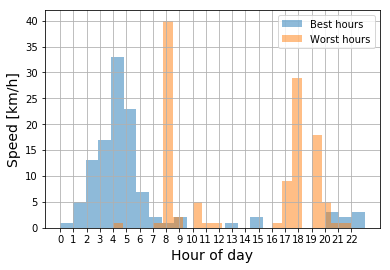

In [105]:
slots['Best_hour'].hist(bins=24, alpha=0.5, label='Best hours')
slots['Worst_hour'].hist(bins=24,alpha=0.5, label='Worst hours')
plt.xlabel('Hour of day',fontsize=14)
plt.ylabel('Speed [km/h]',fontsize=14)
plt.xticks(np.arange(0, 23, 1))
plt.legend()
plt.show()

### Best and worst day of week per (Lcd1, Road_name)

In [106]:
# get the day of the week with Monday=0, Sunday=6
fdt_df = fdt_df.assign(Day_of_week=pd.DatetimeIndex(fdt_df['Date']).dayofweek)

avg_speed_per_day = fdt_df.groupby(['Road_name','Lcd1','Day_of_week'])['Speed'].mean().to_frame().reset_index();
best_days = avg_speed_per_day.loc[avg_speed_per_day.groupby(['Road_name','Lcd1'])['Speed'].idxmax()]
worst_days = avg_speed_per_day.loc[avg_speed_per_day.groupby(['Road_name','Lcd1'])['Speed'].idxmin()]

best_days.columns = ['Road_name','Lcd1','Best_day', 'Speed_best_day'];
worst_days.columns = ['Road_name','Lcd1','Worst_day', 'Speed_worst_day'];

days = pd.merge(best_days,worst_days,how='inner')
days = pd.merge(days, speed_avg, how='inner')
days.head()


,Road_name,Lcd1,Best_day,Speed_best_day,Worst_day,Speed_worst_day,Avg_speed
0,Corso Agnelli(TO),39976,5,42.073118,4,38.826422,40.785637
1,Corso Agnelli(TO),39977,6,39.861472,1,39.538596,39.834844
2,Corso Agnelli(TO),39978,6,32.872138,3,31.532337,32.053441
3,Corso Agnelli(TO),39979,6,29.667607,3,26.833355,28.515671
4,Corso Belgio(TO),39986,1,20.218268,5,18.774194,19.250835


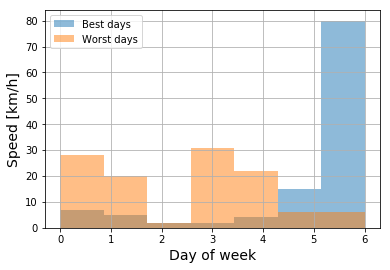

In [107]:
days['Best_day'].hist(bins=7, alpha=0.5, label='Best days')
days['Worst_day'].hist(bins=7,alpha=0.5, label='Worst days')
plt.xlabel('Day of week',fontsize=14)
plt.ylabel('Speed [km/h]',fontsize=14)
plt.legend()
plt.show()

In [6]:
daily_stats = fdt_df;
daily_stats=daily_stats.assign(day=pd.DatetimeIndex(daily_stats['Date']).date);

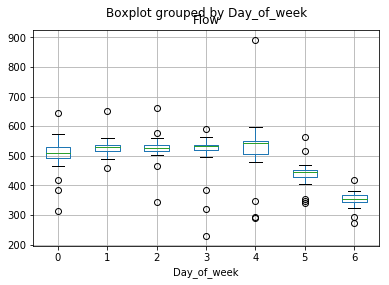

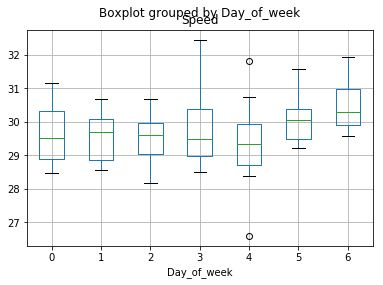

In [109]:
daily_stats_gb_s = daily_stats.groupby(['day','Day_of_week'])['Speed'].mean().to_frame().reset_index();
daily_stats_gb_f = daily_stats.groupby(['day','Day_of_week'])['Flow'].mean().to_frame().reset_index();

daily_stats_gb_f.boxplot(by='Day_of_week', column='Flow')
daily_stats_gb_s.boxplot(by='Day_of_week', column='Speed')
plt.show()

In [110]:
q3=daily_stats_gb_f.groupby(['Day_of_week'])['Flow'].quantile(0.75).reset_index()
q1=daily_stats_gb_f.groupby(['Day_of_week'])['Flow'].quantile(0.25).reset_index()
r=q3-q1;
maximum=q3+1.5*r;
minimum=q1-1.5*r;

d = {'min': minimum['Flow'], 'max': maximum['Flow'], 'Day_of_week' : range(0,7,1)}
min_max = pd.DataFrame(data=d)

tmp=pd.merge(left=daily_stats_gb_f, right=min_max)

outliers=tmp[(tmp['Flow'] > tmp['max']) | (tmp['Flow'] < tmp['min']) ]
outliers=outliers.sort_values(by='day')

### Daily trend

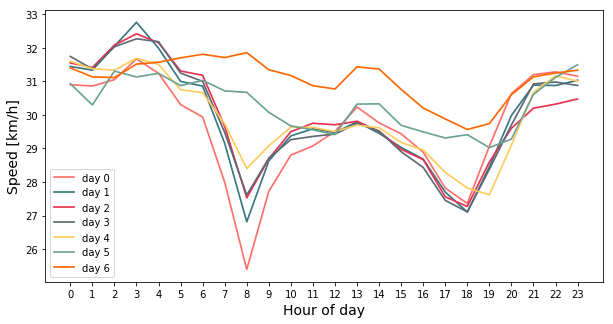

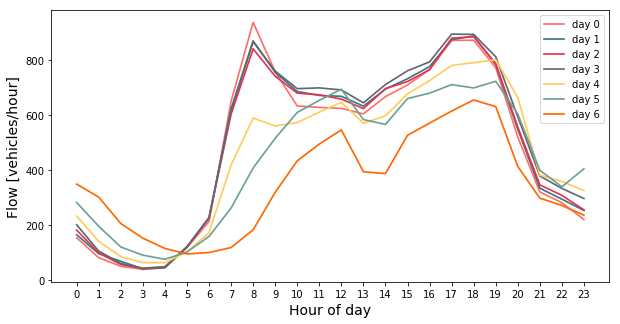

In [111]:
street = fdt_df
speed_per_hour = street.groupby(['Day_of_week', 'Hour_of_day'])['Speed'].mean();
flow_per_hour = street.groupby(['Day_of_week', 'Hour_of_day'])['Flow'].mean();

colors = ['#ff6f69', '#387780', '#E83151', '#5E6973','#ffcc5c', '#6BA292', '#FF6700']
x = np.arange(0, 24, 1)

# Speed
fig, ax = plt.subplots(figsize=(10, 5));
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
for i in range(0,7): 
    plt.plot(x, speed_per_hour[i][x], label=('day '+ str(i)), color=colors[i], linewidth=1.7)

plt.legend()
plt.xlabel('Hour of day',fontsize=14)
plt.ylabel('Speed [km/h]',fontsize=14)
plt.show()

# Flow 
ax = plt.subplots(figsize=(10, 5));
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

for i in range(0,7): 
    plt.plot(x, flow_per_hour[i][x],label=('day '+ str(i)), color=colors[i], linewidth=1.7)

plt.legend()
plt.xlabel('Hour of day',fontsize=14)
plt.ylabel('Flow [vehicles/hour]',fontsize=14)
plt.show()

### Busiest streets 

In [112]:
avg_flow_per_street = fdt_df.groupby(['Road_name'])['Flow'].mean().to_frame().reset_index().sort_values(by='Flow', ascending=False)
avg_flow_per_street.head()

,Road_name,Flow
28,Corso Trieste(TO),1553.048610
31,Corso Unita' D'italia(TO),1552.415734
12,Corso Maroncelli(TO),962.442431
13,Corso Massimo D'azeglio(TO),820.297107
9,Corso Grosseto(TO),758.519713


In [113]:
from datetime import timedelta

In [139]:
# load holidays
holidays_columns = ['day','Name'];
holidays_df = pd.read_csv('holidays.csv', names=holidays_columns, header=0, sep=";");
holidays_df['day'] = lookup(holidays_df['day'],'%Y-%m-%d')
columns = ['day','Name','Day_of_week'];
holidays_df=holidays_df.assign(Day_of_week=pd.DatetimeIndex(holidays_df['day']).dayofweek);
#find long weekends
#holidays_df.head()
lw_df = pd.DataFrame(columns=columns);

for index, row in holidays_df.iterrows():
    lw=None
    if(row['Day_of_week']==0):
        lw=pd.DataFrame([[row['day']-timedelta(days=1),'Long weekend', 6],[row['day']-timedelta(days=2),'Long weekend',5]],columns=columns)
    elif (row['Day_of_week']==4):
        lw=pd.DataFrame([[row['day']+timedelta(days=1),'Long weekend', 5],[row['day']+timedelta(days=2),'Long weekend',6]],columns=columns)
        
    if (lw is not None):
        lw_df=lw_df.append(lw, ignore_index = True)  
    
holidays_df=holidays_df.append(lw_df)
holidays_df.drop_duplicates(subset='day')
holidays_df=holidays_df.sort_values(by='day')
holidays_df

,day,Name,Day_of_week
1,2016-12-24,Long weekend,5.0
0,2016-12-25,Natale,6.0
0,2016-12-25,Long weekend,6.0
1,2016-12-26,Santo Stefano,0.0
2,2016-12-31,San Silvestro,5.0
3,2017-01-01,Capodanno,6.0
4,2017-01-06,Epifania,4.0
2,2017-01-07,Long weekend,5.0
3,2017-01-08,Long weekend,6.0
5,2017-04-25,Liberazione,1.0


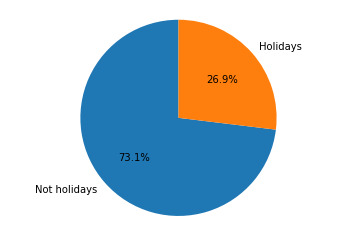

In [204]:
# join between outliers and holidays
holidays_df['day'] = lookup(holidays_df['day'],'%Y-%m-%d')
outliers['day'] = lookup(outliers['day'],'%Y-%m-%d')

outliers = pd.merge(left=outliers, right=holidays_df, how='left', on=['day','Day_of_week'])

matched_perc=(outliers[ outliers['Name'].notnull()].count()/test.count())["day"]*100

fig1, ax1 = plt.subplots()
ax1.pie([100-matched_perc,matched_perc], labels=['Not holidays','Holidays'], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Stationarity test

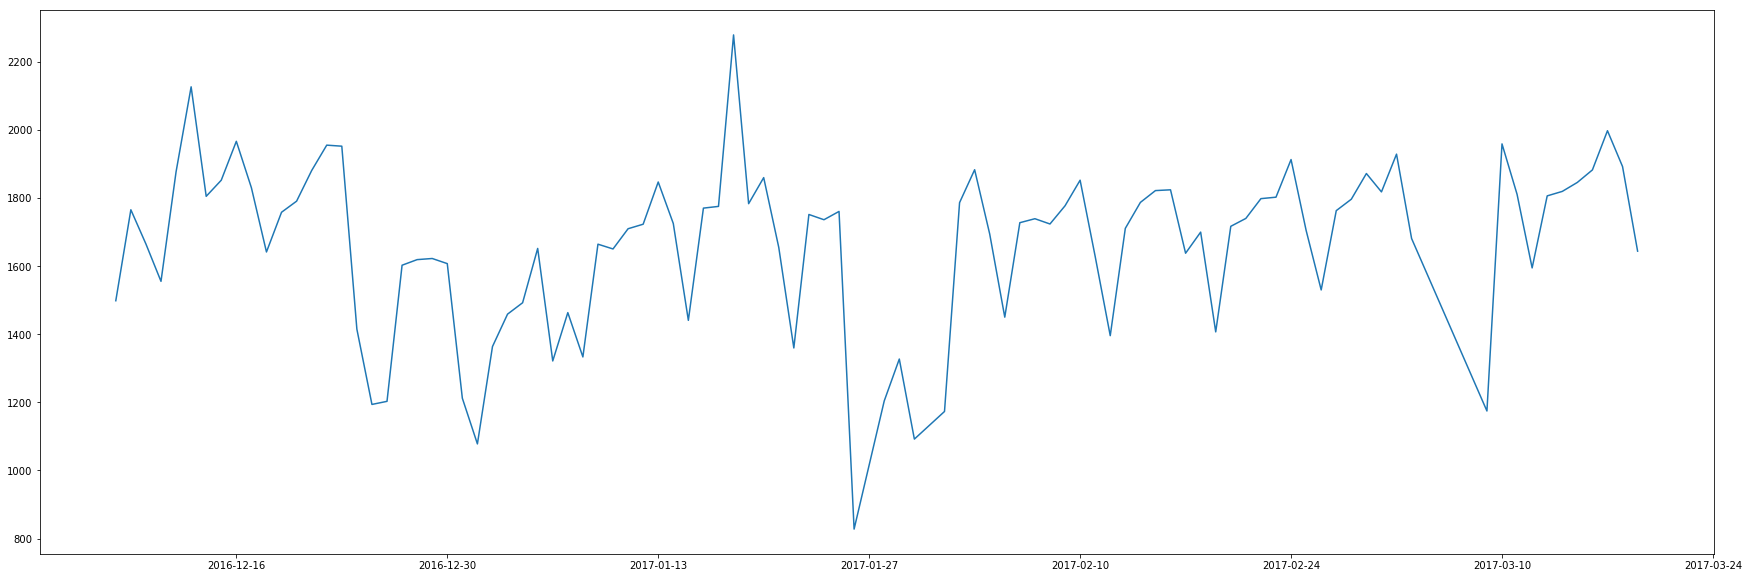

ADF Statistic: -3.226860
p-value: 0.018482
The series is stationary


In [52]:
from statsmodels.tsa.stattools import adfuller

tmp=daily_stats[(fdt_df['Road_name']=='Corso Trieste(TO)') & (fdt_df['Date']<'2017-04-01')].groupby(['day'])['Flow'].mean().to_frame().reset_index()

tmp.x=tmp['day'].T.squeeze()
tmp.y=tmp['Flow'].T.squeeze()

split = tmp.x.count() / 2
split=split.astype(int)

plt.figure(figsize=(30,10))
plt.plot(tmp['day'],tmp['Flow'])
plt.show()

split=split.astype(int)

result = adfuller(tmp.y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if (result[1] <= 0.05):
    print('The series is stationary')
